# Predicting 911 call category

911 is the number most people in the U.S. and some other countries call to get help in a police, fire or medical emergency. An emergency is a life-threatening situation where every second counts, such as a heart attack, child birth in progress, uncontrolled fire, a life-threatening event such as a knife fight, an armed robbery in progress, or a serious car accident. In order to be effective, the emergency system needs to fulfill the following:

- Recognize when someone dials the emergency number on any phone.
- Route the call to the nearest answering point based on the call's originating location.
- Notify the appropriate agency as quickly as possible so it can respond to the emergency

An estimated of 240 million calls are made to 911 in the US each year (nena.org). However, 15%–20% of incoming 911 calls are non-emergencies (e.g. pranks, unintentional calls, etc.). These calls not only waste time and money, they can also be dangerous. If 911 lines or dispatchers are caught up with non-emergencies calls, the risks of not answering or delaying a legitimate emergency increase.

This project targets this situation and creates a model that predicts the category (e.g. robbery, medical, etc.) of a 911 call. This model can make predictions at the time the call is made and continues to do so as the call develops. 

Such a model can be used by different institutions involved in dealing with an emergency from different levels, such as the logistics, funding and deployments:

- City councils.
- Police, fire and medical departments.
- Telephone companies

In addition, from the perspective of the individual experiencing an emergency, it is possible that the likelihood that the emergency is being dealt with succesfully may increase. 


## Data

The dataset used for this projects targets 911 calls made during the first half of 2016 in the city of Detroit. This city was chosen because of its relatively mid-high population, 4.3 million in its metropolitan area, which could allow for this analysis to be extrapolated to other cities. 

The dataset can be found at the following URL:


https://data.world/detroit/detroit-911-calls


The data comes in a .csv file format. It contains 466260 records and 20 columns. The columns contain the following data types: string, integer, boolean and float. Four columns show empty values within them. 

The column 'category', corresponding to the 911 call category, will be the variable to be predicted. This variable contains 35 levels, among them 'accident', 'drugs', 'fire', 'prank/other', 'robbery', etc. The other 19 columns include different information regarding the incident location, call time and date, responding agency and priority codes, different times in dealing with the emergency (e.g. intake time, dispatch time), disposition towards the call and call description. The information contained in the variable call description is given in key words representing the event; no actual transcripts of the caller-dispatcher exchange are given. 

In [1]:
# Import required modules
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import seaborn as sns
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import h2o

# Load data and display dataframe and column names
Detroit = pd.read_csv('/Users/danielvalle/Documents/Coding/Springboard/Capstone project 1 - 911 calls/Detroit_911_calls.csv', encoding='latin-1')
print(Detroit.head())
print('Detroit columns:', sorted(Detroit.columns))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


        callno agency  priority                  incident_address callcode  \
0  HP160970008    DPD        50  WOODWARD AVE   MANCHESTER ST HPK   827050   
1   P161000007    DPD        20              6500 METTETAL ST DET   842020   
2   P160992496    DPD        22               1100 ASHLAND ST DET   843022   
3   P160992494    DPD        30      STOTTER ST   E 7 MILE RD DET   811030   
4   P160992493    DPD        50           3400 E MCNICHOLS RD DET     PKNC   

    calldescription            category calldate  calltime       disposition  \
0     DDOT/BOARDING   DISORDERLY PERSON   4/6/16   8:28:50  NO PROBLEM FOUND   
1  1 DWN/OVR WHL/OD  INVESTIGATE PERSON   4/8/16  23:59:55               NaN   
2  WANTD/WRNT FELON  INVESTIGATE PERSON   4/8/16  23:59:43               NCF   
3                 .            ACCIDENT   4/8/16  23:59:33               NaN   
4    HANG UP/PRANKS         PRANK/OTHER   4/8/16  23:59:12               NaN   

   precinctsca respondingunit  officerinitiated  i

In [2]:
# Inspect the dataset shape and the info stored in the columns
print(Detroit.shape)
print(Detroit.info())

(466260, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466260 entries, 0 to 466259
Data columns (total 20 columns):
callno              466260 non-null object
agency              466260 non-null object
priority            466260 non-null int64
incident_address    463368 non-null object
callcode            466260 non-null object
calldescription     466260 non-null object
category            466260 non-null object
calldate            466260 non-null object
calltime            466260 non-null object
disposition         265695 non-null object
precinctsca         390750 non-null float64
respondingunit      227425 non-null object
officerinitiated    466260 non-null bool
intaketime          466260 non-null float64
dispatchtime        466260 non-null float64
traveltime          466260 non-null float64
totresponsetime     466260 non-null float64
timeonscene         466260 non-null float64
totaltime           466260 non-null float64
location            466260 non-null object
dtypes: bool

In [3]:
# Call categories 
print(sorted(Detroit.category.unique()))
print('Number of call categories:', len(Detroit.category.unique()))

['31', '90', '93', '99', 'ACCIDENT', 'ALARM', 'ANIMAL', 'AR', 'ASSAULT', 'AUTO THEFT', 'BURGLARY', 'DISORDERLY PERSON', 'DRUGS', 'FAMILY TROUBLE', 'FIRE', 'INVESTIGATE PERSON', 'LARCENY', 'MEDICAL', 'OTHER', 'PRANK/OTHER', 'RA', 'RAPE', 'ROBBERY', 'SA', 'SI', 'SPECIAL DETAIL', 'SS', 'T', 'TI', 'TO', 'TRAFFIC', 'TS', 'W3', 'W5', 'W8']
Number of call categories: 35


## Methodology

### Data wrangling and cleaning

The data of the column 'priority' was changed from integer to string in order to reflect and be handled as categorical data. Missing values are filled with 0.


### Feature engineering

Additional features or variables were created in order to provide more fine-grained information with regard to the time and location of the emergency. Since the street and district of the emergency are contained in the 'incident_address' variable, a new variable was created to store the district information: 'district'. Similarly, from the 'location' variable, 'longitude' and 'latitude' variables were extracted. Features for 'year', 'month', and 'day' and 'hour', 'minute', and 'second' were extracted from the 'calldate' and 'calltime' variables, respectively.

In [4]:
# Convert the priority column to object
Detroit['priority'] = Detroit['priority'].astype(object)

# Fill missing values with 0
Detroit.disposition = Detroit.disposition.fillna(0)
Detroit.precinctsca = Detroit.precinctsca.fillna(0)
Detroit.respondingunit = Detroit.respondingunit.fillna(0)

In [5]:
# Extract the district information from the incident address column (eg. DET, HPK)

Detroit['incident_address'] = Detroit['incident_address'].astype(str)
Detroit['district'] = Detroit['incident_address'].apply(lambda x: x[-3:])

# Fill NA values in the column 'district'
Detroit.district = Detroit.district.fillna('XXXX')

# Create a new column for longitude and latitude from 'location' column

def longitude(string):
    '''Look at the values of a string and get the first group of digits containing a decimal, longitude'''
    long = re.findall(r"[-+]?\d*\.\d+", string)[0]
    return long


def latitude(string):
    '''Look at the values of a string and get the first group of digits containing a decimal, latitude'''
    try:
        lat = re.findall(r"[-+]?\d*\.\d+", string)[1]
        return lat
    except:
        return 0.0000

Detroit['longitude'] = Detroit['location'].apply(lambda x: longitude(x)).astype(np.float64)
Detroit['latitude'] = Detroit['location'].apply(lambda x: latitude(x)).astype(np.float64)

# Check if longitude has any negative values
'-' in Detroit['longitude']

# Extract data and hour values and create columns with them

Detroit['calldate'] = pd.to_datetime(Detroit['calldate']) 
Detroit['calltime'] = pd.to_datetime(Detroit['calltime']) 

Detroit['year'] = Detroit['calldate'].apply(lambda x: x.year)
Detroit['month'] = Detroit['calldate'].apply(lambda x: x.month)
Detroit['day'] = Detroit['calldate'].apply(lambda x: x.day)

Detroit['hour'] = Detroit['calltime'].apply(lambda x: x.hour)
Detroit['minute'] = Detroit['calltime'].apply(lambda x: x.minute)
Detroit['second'] = Detroit['calltime'].apply(lambda x: x.second)

## Exploratory data analysis

The present dataset is imbalanced; one level of the target variable corresponds to 45.3% of the observations whereas 25 out of the 35 levels each represent 1% or less of it.

The most frequent category of 911 calls in this dataset is 'prank/other' with 45.3% of the observations. This amounts to more than double of the previously reported rate of prank calls. This situation can potentially be costly and dangerous as prank calls are consuming almost half of the resources assigned to attending the emergencies. The next two most attested categories are 'investigate person' and 'family trouble' with 7.2% and 7.1%, respectively.

Almost all of the calls analyzed here were directed to the Detroit Police Department 'DPD' (94.4%). Thus, there does not seem to be a relationship between the 911 call 'category' and the 'agency' that responded to it.

The most frequent emergency 'code' assigned to the calls was '50', corresponding to traffic accident. This outcome was unexpected because traffic-related emergencies appear at posiiton 14th of the most frequent call 'categories'. However, upon further scrutiny, the reason behind this is that the majority of the most frequent category 'prank/others' were assigned to the priority call '50'. The next most frequent priority codes were '30' for unnecssary use of radio and '20' for location. These call priority codes are attested throughout different call 'categories' sugesting a lack of relationship between them.

911 calls occur least frequently between 4:00am and 5:00am presumably because people are still sleeping. After that point, the number of 911 calls increases reaching its highest point in the period between 4:00pm - 6:00pm, which corresponds to the time were people finish worrk and travel back home. Then, the number of emergency calls decreases throughout the night and early hours of the morning until reaching the lowest point in frequency. With regard to the three most frequent 911 call categories, 'prank/other' calls occur more frequently at 7:00am and noon; although they are highly attested throughout the day as well. As for 'investigate person' and 'family trouble' calls, they do not show a clear preference for a particular hour in the day. 

There are no major variations with regard to the frequency of 911 calls with respect to the month they take place. Furthermore, the 911 call categories do not show a preference or lack thereof for a given month to spike their frequency.

The majority of the 911 calls were initiated by non-police officers. However, certain call 'categories' such 'SA', 'TS', and 'T' were exclusively initiated by a member of the police department, suggesting that this feature may be useful in distinguish two broad types of 911 call categories. 

The majority of the 911 calls are ingested in one to three minutes with certain variation. However, a couple of categories such as 'fire', 'AR', and 'other' tend to be shorter than the average; this could be related to the facility in describing the emergency, e.g. a fire. 

The remaining variables, such as 'traveltime', 'totresponsetime' and 'timeonscene', will not be discussed here because the event they represent occurs only after the emergency call has been completed. The investigation of a possible relationship between call 'category' and 'location' still needs further research and will be further discussed in the future research section. A similar discussion will be carried out in the future research section for the possibility of using the information stored in the variable 'call description' to make better predictions. 

Text(0.5,1,'Call categories percentage')

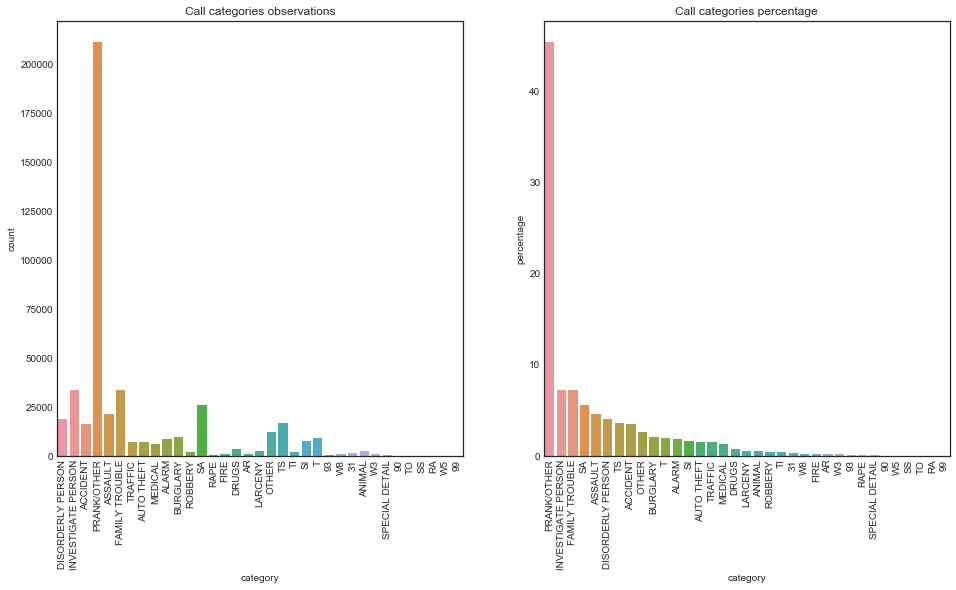

In [6]:
# Obtain value counts and percentages of level of target variable
counts = Detroit['category'].value_counts()
percentage = []

for i in counts:
    valor = i * 100 / len(Detroit)
    percentage.append(valor)

# Create dataframe with value counts and corresponding percentanges for target variable categories
observations = pd.DataFrame(counts)
observations['percentage'] = percentage
observations.columns.values[0] = 'observations'
observations['category'] = observations.index
observations = observations.reset_index(drop=True)

# Make subplots
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
ax1= sns.countplot(x=Detroit.category)
plt.xticks(rotation=90)
ax1.set_title('Call categories observations')
#ax1 = Detroit['category'].value_counts().plot(kind='bar').set_title('Call categories distribution')
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='category', y='percentage', data=observations)
plt.xticks(rotation=90)
ax2.set_title('Call categories percentage')

DPD     439964
WSPD     21151
HPP       5145
Name: agency, dtype: int64

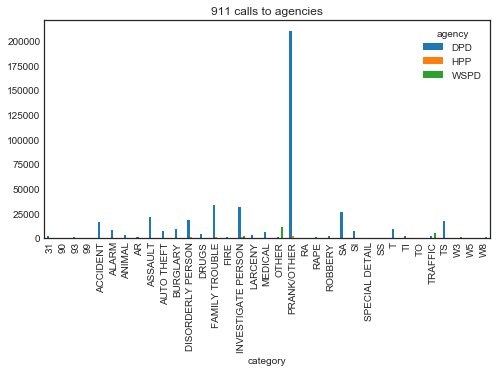

In [7]:
# Category and agency
Detroit.groupby(['category', 'agency']).size().unstack().plot.bar(figsize=(8, 4)).set_title('911 calls to agencies')
Detroit['agency'].value_counts()

(0, 40000)

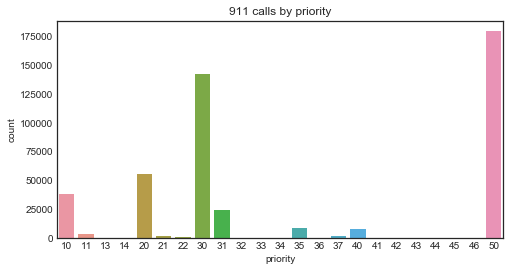

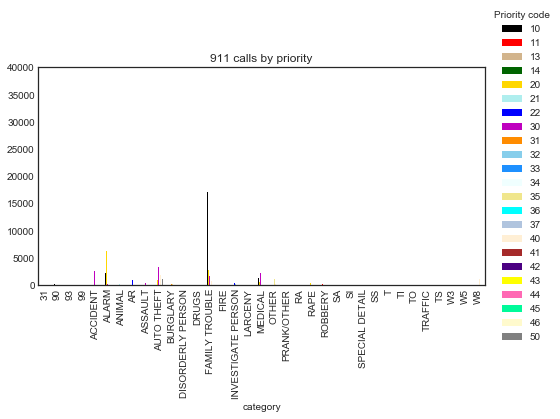

In [8]:
# Category and priority

plt.figure(figsize=(8, 4))
ax4 = sns.countplot(Detroit.priority)
ax4.set_title('911 calls by priority')

colors = ['black', 'red', 'tan', 'darkgreen', 'gold', 'paleturquoise', 'blue', 'm', 'darkorange', 'skyblue', 'dodgerblue', 'azure', 'khaki', 'aqua', 'lightsteelblue', 'papayawhip', 'brown', 'indigo', 'yellow', 'hotpink', 'mediumspringgreen', 'lemonchiffon', 'grey']
Detroit.groupby(['category', 'priority']).size().unstack().plot.bar(figsize=(8, 4), color=colors).set_title('911 calls by priority')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Priority code')
plt.ylim(0, 40000)

Text(0.5,1,'911 call per hour per category')

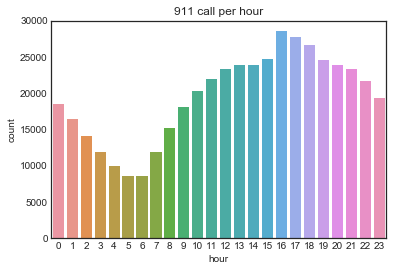

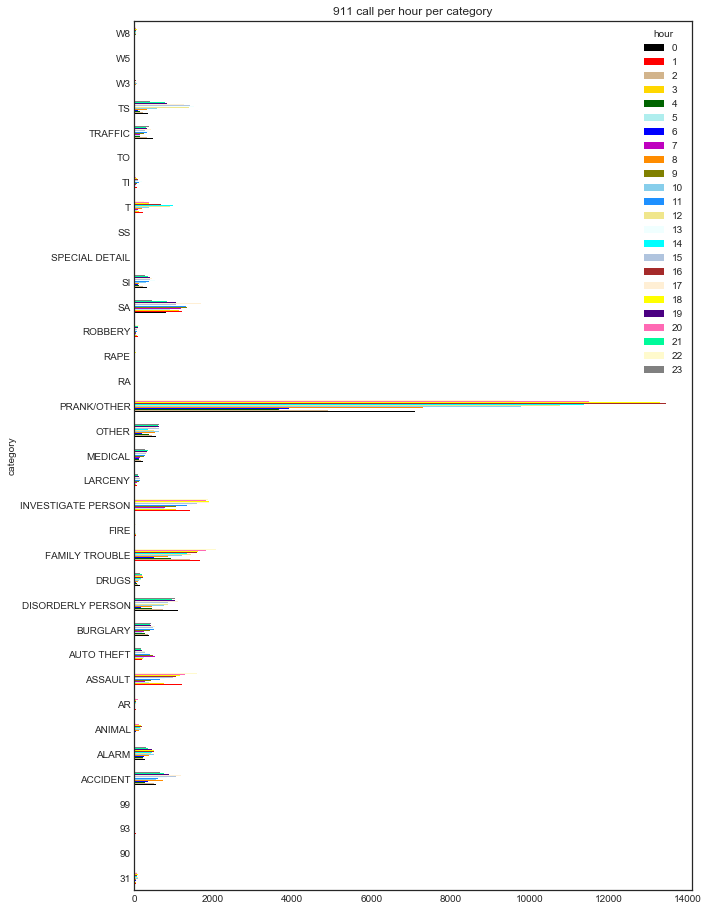

In [9]:
# Category and hour
ax6 = sns.countplot(Detroit.hour)
ax6.set_title('911 call per hour')
colors = ['black', 'red', 'tan', 'gold', 'darkgreen', 'paleturquoise', 'blue', 'm', 'darkorange', 'olive', 'skyblue', 'dodgerblue', 'khaki', 'azure', 'aqua', 'lightsteelblue', 'brown', 'papayawhip', 'yellow', 'indigo', 'hotpink', 'mediumspringgreen', 'lemonchiffon', 'grey']
Detroit.groupby(['category', 'hour']).size().unstack().plot.barh(color=colors, figsize=(10, 16)).set_title('911 call per hour per category')

Text(0.5,1,'911 calls per month per category')

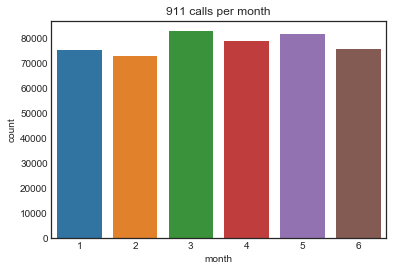

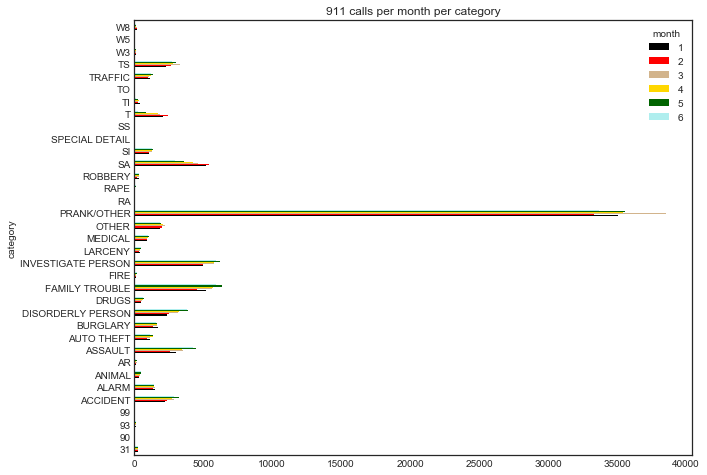

In [10]:
# Category and month
ax7 = sns.countplot(Detroit.month)
ax7.set_title('911 calls per month')
Detroit.groupby(['category', 'month']).size().unstack().plot.barh(color=colors, figsize=(10, 8)).set_title('911 calls per month per category')

Text(0,0.5,'count')

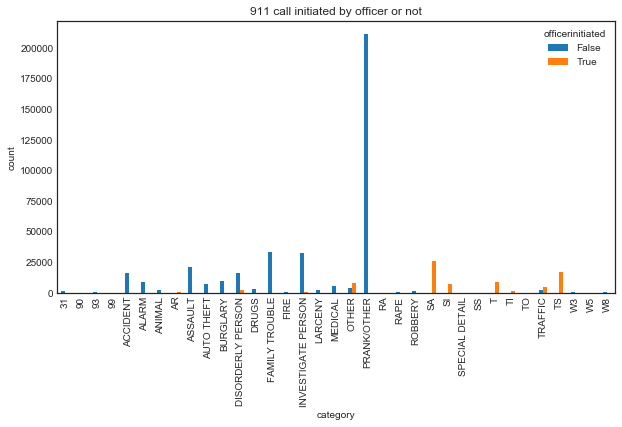

In [11]:
# Category and officer initiated
ax8 = Detroit.groupby(['category', 'officerinitiated']).size().unstack().plot.bar(figsize=(10, 5))
ax8.set_title('911 call initiated by officer or not')
plt.ylabel('count')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

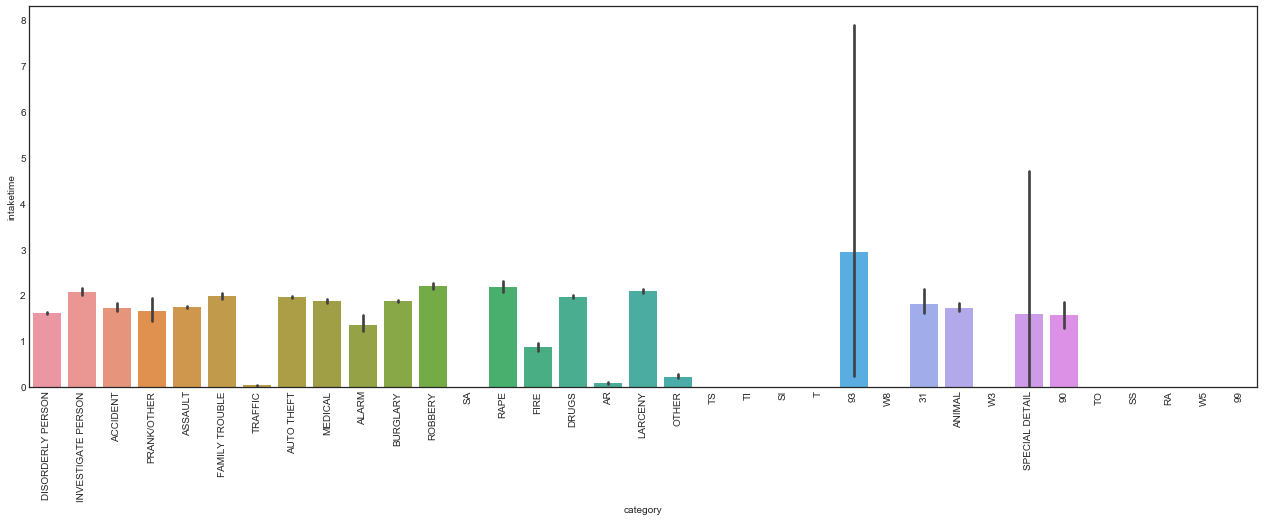

In [12]:
# Category and intaketime
plt.figure(figsize=(22, 7))
sns.barplot(x="category", y="intaketime", data=Detroit)
plt.xticks(rotation=90)

## Modeling


### All features included
This project represents a multiclass classification problem since the target variable contains 35 classes. Furthermore, the dataset combines different data types including strings, integers, floats and booleans. Thus, the random forest algorithm will be prefered for modeling the data. 

Before feeding the data into the random forest classifier, the categorical variables are converted into binary ones since sklearn.ensemble.RandomForestClassifier cannot deal with this type of data. Then, the data is split into 75% for training and 25% for testing. Then, the model is run with 20 trees and all other hyperparameters are left as default. With this basic model setup, the accuracy score on the test data is remarkably high (0.99). From this, the 30 most important features were extracted showing that features related to intaking the emergency call and responding to it were amongst the most relevant as well as some features created from binarization. Given that the dataset is imbalanced, metrics such as recall, precision and f1 can provide a better way to evaluate the model, which in this case shows very high levels. Although it was attempted to perform an ROC AUC metric for this particular model, the current version of scikit learn does not support this type of metric for multiclass classification. Further research needs to address this issue.      

Although this model has a very high performance, it is important to realize that a number of the features fed into the model correspond to information that is available to the emergency responder as the call develops but it is not available to them before the call is made. The next section explores making predictions without those post factum features.  

In [13]:
# Convert categorical variables into binary ones
agency_d = pd.get_dummies(Detroit['agency'])
priority_d = pd.get_dummies(Detroit['priority'])
callcode_d = pd.get_dummies(Detroit['callcode'])
calldescription_d = pd.get_dummies(Detroit['calldescription'])
disposition_d = pd.get_dummies(Detroit['disposition'])
respondingunit_d = pd.get_dummies(Detroit['respondingunit'])
district_d = pd.get_dummies(Detroit['district'])

# Create new dataset with the created binary variables
Detroit_n = pd.concat([Detroit, agency_d, priority_d, callcode_d, calldescription_d, disposition_d, respondingunit_d, district_d], axis=1)

In [14]:
# Next step: separate predictor and target variables
X = Detroit_n[Detroit_n.columns.difference(['category', 'callno', 'callcode', 'incident_address', 'location', 'district', 'agency', 'priority', 'calldescription', 'disposition', 'respondingunit', 'calldate', 'calltime'])]
y = Detroit_n['category']

# Split variables into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define and fit the random forest classifier
forest = RandomForestClassifier(n_estimators=20, random_state=2)
forest.fit(X_train, y_train)

# Review scores
print('train data score:', forest.score(X_train, y_train))
print('test data score:', forest.score(X_test, y_test))

train data score: 0.9999971403651754
test data score: 0.9986702698065457


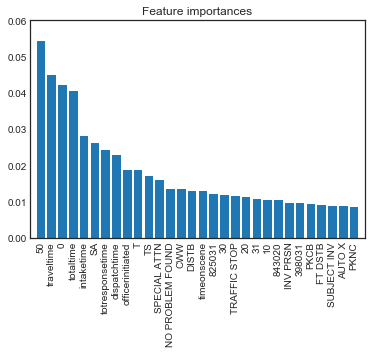

In [16]:
# Identify the 30 most important feature
importances = np.asarray(sorted(forest.feature_importances_, reverse=True)[:30])
indices = np.argsort(importances)[::-1]

# Create labels
X_train = [str(i) for i in X_train]
feature_importance_values = list(zip(forest.feature_importances_, X_train))
features = sorted(feature_importance_values, key = lambda x: x[0], reverse=True)[:30]
labels = [x[1] for x in features]

# Plot 30 most important features
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), labels, rotation=90)
plt.xlim([-1, 30])
plt.ylim([0, 0.06])
plt.show()

Text(0.5,-9.875,'Predicted label')

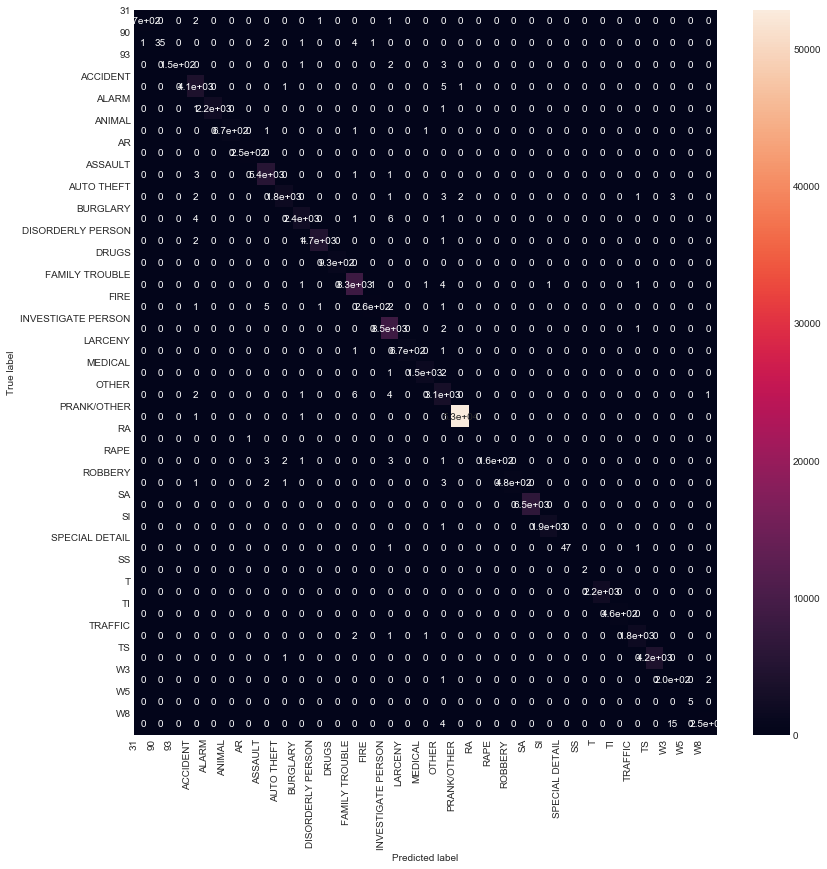

In [17]:
# Create a confusion matrix

# predict_proba = forest.predict_proba(X_test)
y_predict = forest.predict(X_test)
cm = pd.DataFrame(confusion_matrix(np.array(y_test), y_predict))

fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(cm, annot=True)
tick_marks = np.arange(len(y_test.unique()))
plt.xticks(tick_marks, sorted(y_test.unique()), rotation=90)
plt.yticks(tick_marks, sorted(y_test.unique()), rotation=0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [18]:
# Classification report
cl_report = classification_report(y_test, y_predict, sample_weight=None, digits=4)
print(cl_report)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

                31     0.9973    0.9894    0.9934       378
                90     1.0000    0.7955    0.8861        44
                93     1.0000    0.9620    0.9806       158
          ACCIDENT     0.9954    0.9983    0.9968      4080
             ALARM     1.0000    0.9991    0.9996      2235
            ANIMAL     1.0000    0.9955    0.9978       669
                AR     0.9960    1.0000    0.9980       251
           ASSAULT     0.9976    0.9991    0.9983      5393
        AUTO THEFT     0.9972    0.9933    0.9953      1799
          BURGLARY     0.9971    0.9951    0.9961      2457
 DISORDERLY PERSON     0.9996    0.9991    0.9994      4691
             DRUGS     1.0000    1.0000    1.0000       930
    FAMILY TROUBLE     0.9981    0.9989    0.9985      8309
              FIRE     0.9922    0.9624    0.9771       266
INVESTIGATE PERSON     0.9973    0.9996    0.9985      8495
           LARCENY     1.0000    0.9970

In [19]:
# ROC AUC score
# For a multiclass ROC, it seems that scikit-learn does not provide a simple way to obtain it
# Thus, it is necessary to have the data as binary categories and run and one vs. all analysis
# Then, the ROC AUC can be computed

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

y_binary = label_binarize(y, classes=list(np.arange(0, 35)))
n_classes = 35

clf_binary = OneVsRestClassifier(RandomForestClassifier(n_estimators=20, random_state=2))
y_binary_score = clf_binary.fit(X_train, y_binary).predict_proba(X_test)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packag

In [20]:
# This was tried but the model crashed: ValueError: Can only tuple-index with a MultiIndex

# Compute ROC curve and ROC area for each class
#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_binary_score[:, i])
    #roc_auc[i] = auc(fpr[i], tpr[i])

In [21]:
# This was attempted but the model crashed: ValueError: multiclass format is not supported
# ROC auc score

#from sklearn.metrics import roc_auc_score, roc_curve

#y_pred = forest.predict(X_test)
#fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred)
#print(auc(fp_rate, tp_rate))  # 0.857142857143
#print(roc_auc_score(y_test, y_pred))  # 0.857142857143

In [22]:
print(Detroit['category'].value_counts())
print(len(Detroit['category']))

PRANK/OTHER           211566
INVESTIGATE PERSON     33730
FAMILY TROUBLE         33507
SA                     26084
ASSAULT                21411
DISORDERLY PERSON      19056
TS                     16962
ACCIDENT               16465
OTHER                  12146
BURGLARY                9657
T                       9300
ALARM                   8837
SI                      7396
AUTO THEFT              7136
TRAFFIC                 7106
MEDICAL                 5908
DRUGS                   3609
LARCENY                 2707
ANIMAL                  2627
ROBBERY                 1956
TI                      1819
31                      1667
W8                      1045
FIRE                    1025
AR                       985
W3                       820
93                       670
RAPE                     574
SPECIAL DETAIL           240
90                       187
W5                        28
SS                        22
TO                         7
RA                         4
99            

In [23]:
# Proportion of the observations of the 3 most frequent classes in targer variable
print('prank/other:', 211566/466260, '% of the data')
print('investigate person:', 33730/466260, '% of the data')
print('family trouble:', 33507/466260, '% of the data')

prank/other: 0.4537511259812122 % of the data
investigate person: 0.07234161197615065 % of the data
family trouble: 0.0718633380517308 % of the data


### Only pre-fact features included

Now, a similar model as the one presented above will be run disregarding features that correspond to information that has been 'learned' by the emergency respondent as the emergency call develops such as 'incident_address', 'intaketime', 'traveltime', 'timeonscene'. The train and test sets again represent .75 and .25 of all the data, respectively. The model is run with 20 trees, as in the previous model, and the other hyperparameters have the default values. As in the previous model, the accuracy score on the test data is high (.98) even when considering imbalanced data. For this run of the model the 30 most important features are mostly represented by those features created by binarizing (dummy) the 'calldescription' feature of the original dataset such as 'special attn', 'hang up/pranks', 'traffic stop'. This suggests that the algorithm is making the classification decisions based heavily on the call category. Since this is also information that is only known once the caller has communicated it to the emergency responder, it constitutes information learned as the call develops or when the call ends. In the next section we are going to remove this feature from the dataset to test the predictions with only data known before the call.  

In [24]:
### Disregard information that has been learned at the time of the call
pf_columns = ['callno', 'agency', 'priority', 'incident_address', 'callcode', 'disposition',
       'precinctsca', 'respondingunit', 'officerinitiated', 'intaketime',
       'dispatchtime', 'traveltime', 'totresponsetime', 'timeonscene',
       'totaltime', 'location', 'calldescription', 'calldate', 'calltime', 'district']

Detroit_pf = Detroit[Detroit.columns.difference(pf_columns)]
Detroit_pf = pd.concat([Detroit_pf, district_d, calldescription_d], axis=1)

In [25]:
# Separate predictor and target variables
X_pf = Detroit_pf[Detroit_pf.columns.difference(['category'])]
y_pf = Detroit_pf['category']

# Split variables into train and test sets 
X_pf_train, X_pf_test, y_pf_train, y_pf_test = train_test_split(X_pf, y_pf, test_size=0.25, random_state=42)

# Define and fit the random forest classifier
forest_pf = RandomForestClassifier(n_estimators=20, random_state=2)
forest_pf.fit(X_pf_train, y_pf_train)

# Review scores
print('train data score:', forest_pf.score(X_pf_train, y_pf_train))
print('test data score:', forest_pf.score(X_pf_test, y_pf_test))

train data score: 0.99988275497219
test data score: 0.9813408827692703


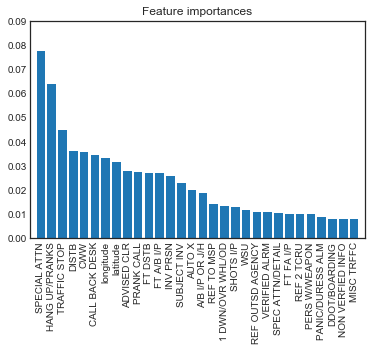

In [26]:
# Plot the 30 most important features 

importances_pf = np.asarray(sorted(forest_pf.feature_importances_, reverse=True)[:30])
indices_pf = np.argsort(importances_pf)[::-1]

# Create labels
X_pf_train = [str(i) for i in X_pf_train]
feature_importance_values_pf = list(zip(forest_pf.feature_importances_, X_pf_train))
features_pf = sorted(feature_importance_values_pf, key = lambda x: x[0], reverse=True)[:30]
labels_pf = [x[1] for x in features_pf]

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices_pf)), importances_pf[indices_pf], align="center")
plt.xticks(range(len(indices_pf)), labels_pf, rotation=90)
plt.xlim([-1, 30])
plt.ylim([0, 0.09])
plt.show()

### No call description data

In addition to the features removed in the last run of the algorithm, the 'calldescription' feature was not considered in this third model. Again, the test and train data were divided into 3/4 and 1/4 of the total data. The random forest classifier was run with 20 trees and the defefault hyperparameters. Now we see a significant change in the accuracy score on the test data which drops to .47. This result sharply contrasts with the previous results where all the data and features learned during the call except 'calldescription' were removed. Thus, this result indicates that it is the feature 'calldescription' that is responsible for the algorithm to learn better in the previous models, but the lack of it makes the model perform worse. 

Now that the model performance has dropped very low, we will aim at improving it. To this end, we will look for the optimal hyperparameters using a grid search; for the number of trees, the values considered are 200, 250, and 300 and for the maximun tree depth, the values considered are 35, 45, and 55. The optimal hyperparameters of this grid search are stored in the best_forest object.  

Even for the best forest, the accuracy score was low at .49. This is just a small increment from the model with default hyperparameters. Other metrics such as the confusion matrix and the precision (.43), recall (.49) and f1 (0.35) also decreased significantly. 

One option tried to improve the model accuracy was to run a model with the categorical features as such, without turning them into binary (dummy) features. Random forests in scikit-learn currently do not allow for this option. The h20 library was used for this task since it allows random forest classifiers to use categorical variables as such. The results of using the categorical features as such did not make a significant difference. We will keep the scikit learn model instead for simplicity since both models produce similar results. 

Given that the dataset is imbalaced where the three most frequent classes represent approximately 45%, 7%, and 7% of all the data, it is possible that resampling the data could improve the model performance. We try this next. In downsampling, the majority class 'prank/other' was reduced from 211566 to 33730 observations; all other classes remained the same. The random forest classifier was run with the same hyperparameters as the best forest identified by the grid seach performed above. The model with the downsampled data performed worse across the board than the model with unmodified imbalanced data: test accuracy score .28, precision .27, recall .28, f1 .25. Then, oversampling the data was tried. The non-majority classes were each oversampled to 34000 observations; the majority class was left unchanged. The accuracy score for the oversampled dataset was .48 whith precision at .37, recall at .48 and f1 at .36. 

Given the results of the best forest classifier (with tuned hyperparameters) and the resampled data, it is clear that the model performance stays below .5 for all the metrics tested when the data does not include information available at the time the emergency call develops. Because of this limitation, we changed the main goal of the predicting model, instead aiming at predicting only one call category for each emergerncy call, we provide three possible call categories for the emergency. This approach is discussed next.     

In [15]:
# Do the same for a dataset without calldescription
### Fit a model without considering predictors that might be collected after the emergency
nocd_columns = ['callno', 'agency', 'priority', 'incident_address', 'callcode', 'disposition',
       'precinctsca', 'respondingunit', 'officerinitiated', 'intaketime',
       'dispatchtime', 'traveltime', 'totresponsetime', 'timeonscene',
       'totaltime', 'location', 'calldescription', 'calldate', 'calltime', 'district']

Detroit_nocd = Detroit[Detroit.columns.difference(nocd_columns)]
Detroit_nocd = pd.concat([Detroit_nocd, district_d], axis=1)

In [16]:
# Separate predictor and target variables
X_nocd = Detroit_nocd[Detroit_nocd.columns.difference(['category'])]
y_nocd = Detroit_nocd['category']

# Split variables into train and test sets 
X_nocd_train, X_nocd_test, y_nocd_train, y_nocd_test = train_test_split(X_nocd, y_nocd, test_size=0.25, random_state=42)

# Define and fit the random forest classifier
forest_nocd = RandomForestClassifier(n_estimators=20, random_state=2)
forest_nocd.fit(X_nocd_train, y_nocd_train)

# Review scores
print('train data score:', forest_nocd.score(X_nocd_train, y_nocd_train))
print('test data score:', forest_nocd.score(X_nocd_test, y_nocd_test))

train data score: 0.9988618653397962
test data score: 0.46948054733410544


In [42]:
# Find optimal hyperparameters to improve model performance

# Create parameters for grid search
params_grid = {'n_estimators': [200, 250, 300], 'max_depth': [35, 45, 55]}

# Initialize a RandomForestClassifier
forest_grid = RandomForestClassifier(random_state=10)

# Perform 10-fold cross-validation
grid = GridSearchCV(forest_grid, params_grid, cv=10)
grid.fit(X_nocd_train, y_nocd_train)

# Get best forest
best_forest_grid = grid.best_estimator_

# Review scores
print('train data score:', best_forest_grid.score(X_nocd_train, y_nocd_train))
print('test data score:', best_forest_grid.score(X_nocd_test, y_nocd_test))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


train data score: 0.996059423212
test data score: 0.485274310471


In [43]:
best_forest_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=55, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [17]:
# Get the best hyperparameters of the above parameter tuning on a single tree only
# Define and fit the random forest classifier
best_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=55, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)
best_forest.fit(X_nocd_train, y_nocd_train)

# Review scores
print('train data score:', best_forest.score(X_nocd_train, y_nocd_train))
print('test data score:', best_forest.score(X_nocd_test, y_nocd_test))

train data score: 0.9960594232116559
test data score: 0.4852743104705529


In [ ]:
# Create a confusion matrix
# predict_proba = forest.predict_proba(X_test)
y_predict_nocd = best_forest.predict(X_nocd_test)
cm_nocd = pd.DataFrame(confusion_matrix(np.array(y_nocd_test), y_predict_nocd))

fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(cm_nocd, annot=True)
tick_marks = np.arange(len(y_nocd_test.unique()))
plt.xticks(tick_marks, sorted(y_nocd_test.unique()), rotation=90)
plt.yticks(tick_marks, sorted(y_nocd_test.unique()), rotation=0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# Classification report
cl_report_nocd = classification_report(y_nocd_test, y_predict_nocd, sample_weight=None, digits=4)
print(cl_report_nocd)

In [ ]:
# 30 most important features - best forest from grid search
importances_bf = np.asarray(sorted(best_forest.feature_importances_, reverse=True)[:30])
indices_bf = np.argsort(importances_bf)[::-1]

# Create labels
X_bf_train = [str(i) for i in X_nocd_train]
feature_importance_values_bf = list(zip(best_forest.feature_importances_, X_nocd_train))
features_bf = sorted(feature_importance_values_bf, key = lambda x: x[0], reverse=True)[:30]
labels_bf = [x[1] for x in features_bf]

plt.figure()
plt.title("Feature importances - best forest from grid search")
plt.bar(range(len(indices_bf)), importances_bf[indices_bf], align="center")
plt.xticks(range(len(indices_bf)), labels_bf, rotation=90)
plt.xlim([-1, 30])
plt.ylim([0, 0.09])
plt.show()

In [32]:
#H20 library
# Use H2O in order to run the random forest with categorical variables without changind them to dummy variables
# In order to be able to connect to H2O, it is necessary to have Java 7 or later. 
# Even when a version of Java 7 or later is installed, it may not be used at the time by python
# Check which Java version is being used by using the following commnad on the terminal: java -version
# If it is not the right java version, change it to the desire one with: export PATH="/Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home/bin:$PATH"
# Double check that the right version of Java is used
# Now, H2O may be run and initialized
# Close a cluster : h2o.cluster().shutdown() or h2o.shutdown()
# Notice that h2o may need to be run first in the terminal: python3 > import h2o > h2o.init()
# Check status: h2o.cluster_info()

h2o.init(max_mem_size='12G', min_mem_size='5G')             #specify max number of bytes. uses all cores by default.
h2o.remove_all()       #clean slate, in case cluster was already running

from h2o.estimators import H2ORandomForestEstimator

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,13 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.19.0.4216
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_danielvalle_a8x7gd
H2O cluster total nodes:,1
H2O cluster free memory:,10.55 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [33]:
# Create pandas dataframe with only the columns that will be used in the h2o random forest classifier
noh20_columns = ['callno', 'agency', 'priority', 'incident_address', 'callcode', 'calldescription', 'calldate', 'calltime', 'disposition', 'precinctsca', 'respondingunit', 'officerinitiated', 'intaketime', 'dispatchtime', 'traveltime', 'totresponsetime', 'timeonscene', 'totaltime', 'location']
Detroit_h2o = Detroit[Detroit.columns.difference(noh20_columns)]
print(len(Detroit_h2o.columns))
Detroit_h2o.head(5)

10


,category,day,district,hour,latitude,longitude,minute,month,second,year
0,DISORDERLY PERSON,6,HPK,8,-83.098119,42.407050,28,4,50,2016
1,INVESTIGATE PERSON,8,DET,23,-83.204668,42.338525,59,4,55,2016
2,INVESTIGATE PERSON,8,DET,23,-82.940859,42.375307,59,4,43,2016
3,ACCIDENT,8,DET,23,-83.025291,42.433906,59,4,33,2016
4,PRANK/OTHER,8,DET,23,-83.066390,42.418630,59,4,12,2016


In [34]:
# Import dataframe from a pandas dataframe into an H20frame
data_h2o = h2o.H2OFrame(Detroit_h2o)    # Alternatively, data = h2o.import_file('path')
data_h2o.head(5)

# Separate the X and y variables
X_h2ocolumns = ['day', 'district', 'hour', 'latitude', 'longitude', 'minute', 'month', 'second', 'year']
y_h2ocolumn = 'category'

# Divide train and test data
# Ratios: specifies the proportion of the data for train, test (and validation if added)
train, test = data_h2o.split_frame(ratios=[0.75], seed=42)

# Define random forest classifier (estimator)
rf_h2o = H2ORandomForestEstimator(ntrees=150, max_depth=40)

# Train the model
rf_h2o.train(x=X_h2ocolumns, y=y_h2ocolumn, training_frame=train)

# Model performance
performance = rf_h2o.model_performance(test_data=test)

print(performance)



Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.5577367083665578
RMSE: 0.7468177209778553
LogLoss: 1.8960461856808741
Mean Per-Class Error: 0.8987721862777399
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



31,90,93,99,ACCIDENT,ALARM,ANIMAL,AR,ASSAULT,AUTO THEFT,BURGLARY,DISORDERLY PERSON,DRUGS,FAMILY TROUBLE,FIRE,INVESTIGATE PERSON,LARCENY,MEDICAL,OTHER,PRANK/OTHER,RA,RAPE,ROBBERY,SA,SI,SPECIAL DETAIL,SS,T,TI,TO,TRAFFIC,TS,W3,W5,W8,Error,Rate
1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,12.0,0.0,3.0,0.0,1.0,3.0,437.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.9978992,475 / 476
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43 / 43
0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,6.0,119.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.9395973,140 / 149
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0 / 0
0.0,0.0,0.0,0.0,177.0,2.0,1.0,0.0,28.0,0.0,2.0,6.0,1.0,62.0,0.0,60.0,0.0,0.0,78.0,3557.0,0.0,0.0,0.0,44.0,1.0,0.0,0.0,8.0,2.0,0.0,7.0,17.0,0.0,0.0,0.0,0.9563286,"3,876 / 4,053"
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,11.0,1.0,1.0,10.0,0.0,38.0,0.0,33.0,0.0,1.0,8.0,3555.0,0.0,0.0,0.0,60.0,7.0,0.0,0.0,28.0,0.0,0.0,5.0,364.0,0.0,0.0,0.0,0.9118644,"3,766 / 4,130"
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,83.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,1.0,201 / 201
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7 / 7
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0,0.0,0.0,135.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1.0,0.0,0.0,3.0,0.9891697,274 / 277



See the whole table with table.as_data_frame()
Top-10 Hit Ratios: 


k,hit_ratio
1,0.4909422
2,0.5976000
3,0.6695471
4,0.7252167
5,0.7683368
6,0.8035544
7,0.8329139
8,0.8570079
9,0.8779752
10,0.8958503


In [39]:
rf_h2o.confusion_matrix(test).as_data_frame()
# Call Flow: http://127.0.0.1:54321/flow/index.html
h2o.cluster().shutdown()  # Close the h20 connection

H2O session _sid_a13a closed.


In [30]:
# Downsampling
# Separate the majority set and the rest
majority = Detroit_nocd[Detroit_nocd.category == 'PRANK/OTHER']
rest = Detroit_nocd[Detroit_nocd.category != 'PRANK/OTHER']

# Downsample majority class
# Sample without replacement: replace=False
from sklearn.utils import resample   # Import resample module

majority_downsampled = resample(majority, replace=False, n_samples=33730, random_state=123)

# Info about donwsampled variable dataset
majority_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33730 entries, 87051 to 128801
Columns: 720 entries, category to nan
dtypes: float64(2), int64(6), object(1), uint8(711)
memory usage: 25.4+ MB


In [31]:
# Combine minority classes with downsampled majority class
Detroit_nocd_downsampled = pd.concat([majority_downsampled, rest])

# Train model on downsampled dataset
X_nocd_ds = Detroit_nocd_downsampled[Detroit_nocd_downsampled.columns.difference(['category'])]
y_nocd_ds = Detroit_nocd_downsampled['category']

# Split variables into train and test sets 
X_nocd_ds_train, X_nocd_ds_test, y_nocd_ds_train, y_nocd_ds_test = train_test_split(X_nocd_ds, y_nocd_ds, test_size=0.25, random_state=42)

best_forest.fit(X_nocd_ds_train, y_nocd_ds_train)

# Review scores
print('downsampled train data score:', best_forest.score(X_nocd_ds_train, y_nocd_ds_train))
print('downsampled test data score:', best_forest.score(X_nocd_ds_test, y_nocd_ds_test))

downsampled train data score: 0.9978642554017696
downsampled test data score: 0.27642637228524675


Text(0.5,1,'Confusion matrix - downsampled dataset')

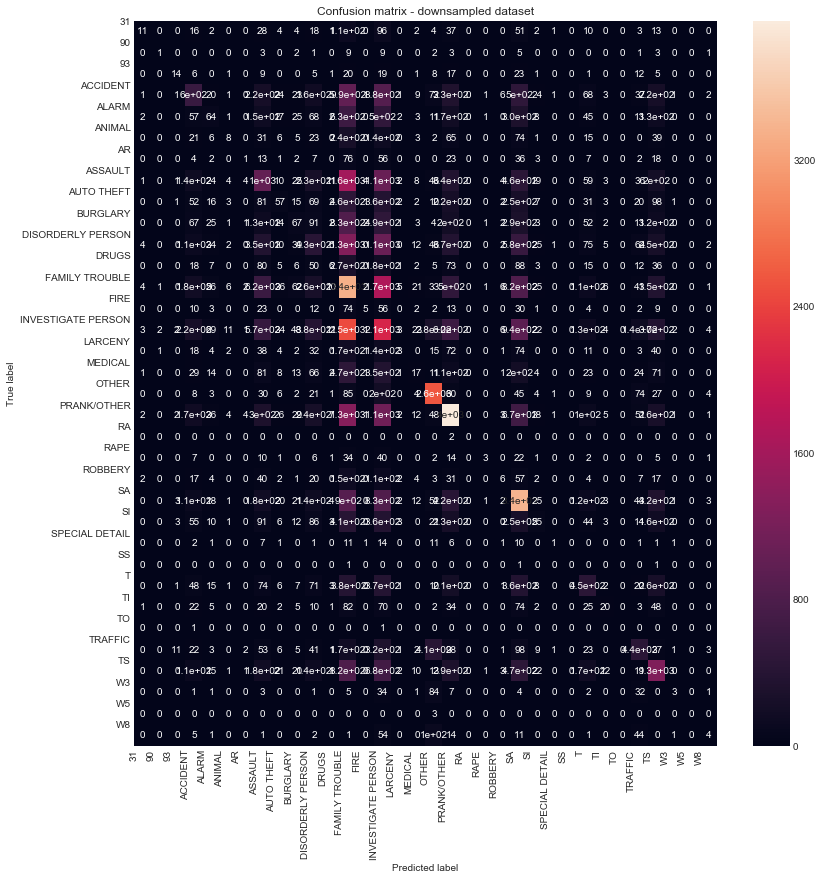

In [32]:
# Confusion matrix
y_predict_nocd_ds = best_forest.predict(X_nocd_ds_test)
cm_nocd_ds = pd.DataFrame(confusion_matrix(np.array(y_nocd_ds_test), y_predict_nocd_ds))

fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(cm_nocd_ds, annot=True)
tick_marks = np.arange(len(y_nocd_ds_test.unique()))
plt.xticks(tick_marks, sorted(y_nocd_ds_test.unique()), rotation=90)
plt.yticks(tick_marks, sorted(y_nocd_ds_test.unique()), rotation=0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix - downsampled dataset')

In [33]:
# Classification report
cl_report_nocd_ds = classification_report(y_nocd_ds_test, y_predict_nocd_ds, sample_weight=None, digits=4)
print(cl_report_nocd_ds)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

                31     0.3438    0.0264    0.0490       417
                90     0.2000    0.0250    0.0444        40
                93     0.3590    0.0979    0.1538       143
          ACCIDENT     0.2822    0.1429    0.1897      4199
             ALARM     0.1397    0.0291    0.0482      2199
            ANIMAL     0.1667    0.0118    0.0220       680
                AR     0.0625    0.0040    0.0075       251
           ASSAULT     0.2300    0.1904    0.2083      5330
        AUTO THEFT     0.1743    0.0320    0.0541      1779
          BURGLARY     0.1523    0.0278    0.0471      2408
 DISORDERLY PERSON     0.1600    0.0895    0.1148      4791
             DRUGS     0.0741    0.0069    0.0127       864
    FAMILY TROUBLE     0.1918    0.4078    0.2609      8223
              FIRE     0.2500    0.0203    0.0376       246
INVESTIGATE PERSON     0.1561    0.2482    0.1917      8482
           LARCENY     0.0882    0.0047

In [18]:
# Oversampling the smallest classes
# Create X and y,  split into train and test and then resample only on the train data
X_nocd_us = Detroit_nocd[Detroit_nocd.columns.difference(['category'])]
y_nocd_us = Detroit_nocd['category']

# Split variables into train and test sets 
X_nocd_us_train, X_nocd_us_test, y_nocd_us_train, y_nocd_us_test = train_test_split(X_nocd_us, y_nocd_us, test_size=0.25, random_state=42)

In [19]:
# Load imblearn 
from imblearn.over_sampling import RandomOverSampler

In [20]:
# Resample data
ros = RandomOverSampler(ratio={'31': 34000, '90': 34000, '93': 34000, '99': 34000, 'ACCIDENT': 34000, 'ALARM': 34000, 
 'ANIMAL': 34000, 'AR': 34000, 'ASSAULT': 34000, 'AUTO THEFT': 34000, 'BURGLARY': 34000, 'DISORDERLY PERSON': 34000, 
 'DRUGS': 34000, 'FAMILY TROUBLE': 34000, 'FIRE': 34000, 'INVESTIGATE PERSON': 34000, 'LARCENY': 34000, 
 'MEDICAL': 34000, 'OTHER': 34000, 'PRANK/OTHER': 34000, 'RA': 34000, 'RAPE': 34000, 'ROBBERY': 34000, 'SA': 34000, 
 'SI': 34000, 'SPECIAL DETAIL': 34000, 'SS': 34000, 'T': 34000, 'TI': 34000, 'TO': 34000, 'TRAFFIC': 34000, 
 'TS': 34000, 'W3': 34000, 'W5': 34000, 'W8': 34000, 'PRANK/OTHER': 158764}, random_state=0)
X_nocd_us_train_resampled, y_nocd_us_train_resampled = ros.fit_sample(X_nocd_us_train, y_nocd_us_train)

In [21]:
# Check the number of observations for each class in the oversampled y (target variable)
unique, counts = np.unique(y_nocd_us_train_resampled, return_counts=True)
dict(zip(unique, counts))

{'31': 34000,
 '90': 34000,
 '93': 34000,
 '99': 34000,
 'ACCIDENT': 34000,
 'ALARM': 34000,
 'ANIMAL': 34000,
 'AR': 34000,
 'ASSAULT': 34000,
 'AUTO THEFT': 34000,
 'BURGLARY': 34000,
 'DISORDERLY PERSON': 34000,
 'DRUGS': 34000,
 'FAMILY TROUBLE': 34000,
 'FIRE': 34000,
 'INVESTIGATE PERSON': 34000,
 'LARCENY': 34000,
 'MEDICAL': 34000,
 'OTHER': 34000,
 'PRANK/OTHER': 158764,
 'RA': 34000,
 'RAPE': 34000,
 'ROBBERY': 34000,
 'SA': 34000,
 'SI': 34000,
 'SPECIAL DETAIL': 34000,
 'SS': 34000,
 'T': 34000,
 'TI': 34000,
 'TO': 34000,
 'TRAFFIC': 34000,
 'TS': 34000,
 'W3': 34000,
 'W5': 34000,
 'W8': 34000}

In [22]:
# Fit the model
best_forest.fit(X_nocd_us_train_resampled, y_nocd_us_train_resampled)

# Review scores
print('downsampled train data score:', best_forest.score(X_nocd_us_train_resampled, y_nocd_us_train_resampled))
print('downsampled test data score:', best_forest.score(X_nocd_us_test, y_nocd_us_test))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

Text(0.5,1,'Confusion matrix - upsampled dataset')

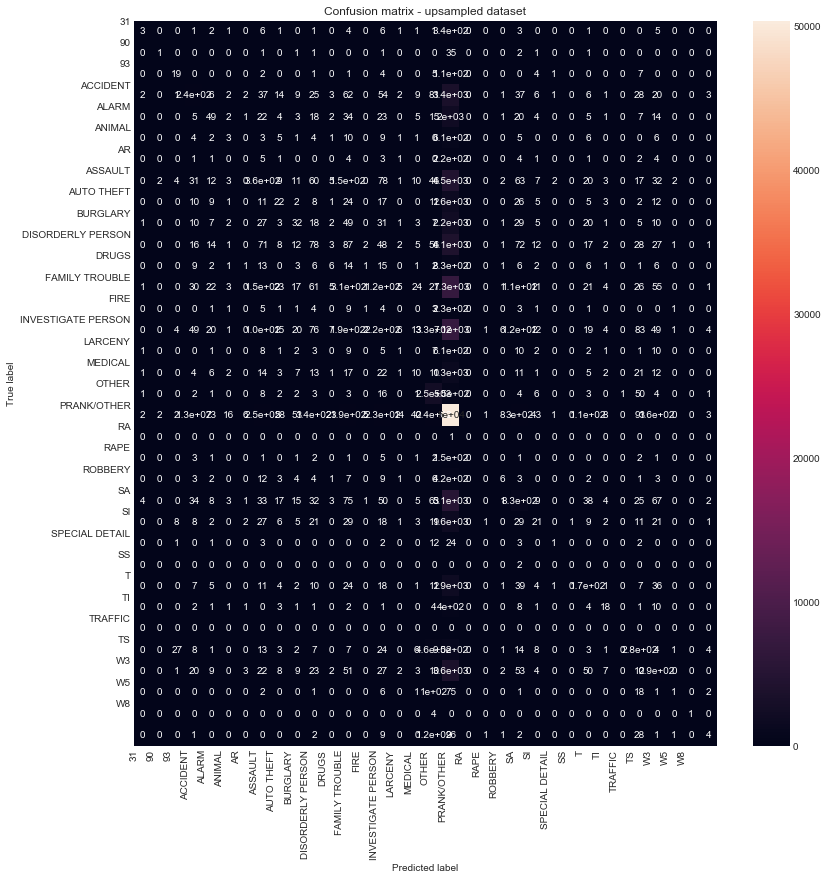

In [24]:
# Confusion matrix
y_predict_nocd_us = best_forest.predict(X_nocd_us_test)
cm_nocd_us = pd.DataFrame(confusion_matrix(np.array(y_nocd_us_test), y_predict_nocd_us))

fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(cm_nocd_us, annot=True)
tick_marks = np.arange(len(y_nocd_us_test.unique()))
plt.xticks(tick_marks, sorted(y_nocd_us_test.unique()), rotation=90)
plt.yticks(tick_marks, sorted(y_nocd_us_test.unique()), rotation=0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix - upsampled dataset')

In [25]:
# Classification report
cl_report_nocd_us = classification_report(y_nocd_us_test, y_predict_nocd_us, sample_weight=None, digits=4)
print(cl_report_nocd_us)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                    precision    recall  f1-score   support

                31     0.1875    0.0079    0.0152       378
                90     0.2000    0.0227    0.0408        44
                93     0.2836    0.1203    0.1689       158
          ACCIDENT     0.3850    0.0591    0.1024      4080
             ALARM     0.1899    0.0219    0.0393      2235
            ANIMAL     0.0698    0.0045    0.0084       669
                AR     0.0000    0.0000    0.0000       251
           ASSAULT     0.2919    0.0662    0.1079      5393
        AUTO THEFT     0.1028    0.0122    0.0219      1799
          BURGLARY     0.1488    0.0130    0.0240      2457
 DISORDERLY PERSON     0.1252    0.0166    0.0294      4691
             DRUGS     0.0952    0.0065    0.0121       930
    FAMILY TROUBLE     0.2000    0.0378    0.0636      8309
              FIRE     0.0769    0.0038    0.0072       266
INVESTIGATE PERSON     0.2065    0.0263    0.0466      8495
           LARCENY     0.0250    0.0015

In [165]:
# Calibrated classifier
# Initialize the calibration object
calibration = CalibratedClassifierCV(best_forest, cv='prefit')

In [166]:
# Fit the calibration to the data
calibration.fit(X_nocd_train, y_nocd_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=55, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
            cv='prefit', method='sigmoid')

In [167]:
# Review scores
print('train data score:', calibration.score(X_nocd_train, y_nocd_train))
print('test data score:', calibration.score(X_nocd_test, y_nocd_test))

train data score: 0.9981555355381118
test data score: 0.4211984729550036


In [168]:
# Predict probabilities
y_pred_calibration = calibration.predict_proba(X_nocd_test)

In [169]:
# Predict X
y_predicted_calibration = calibration.predict(X_nocd_test)

In [170]:
y_predicted_calibration

array(['DRUGS', 'PRANK/OTHER', 'PRANK/OTHER', ..., 'PRANK/OTHER',
       'INVESTIGATE PERSON', 'TS'], dtype='<U18')

Text(0.5,-9.875,'Predicted label')

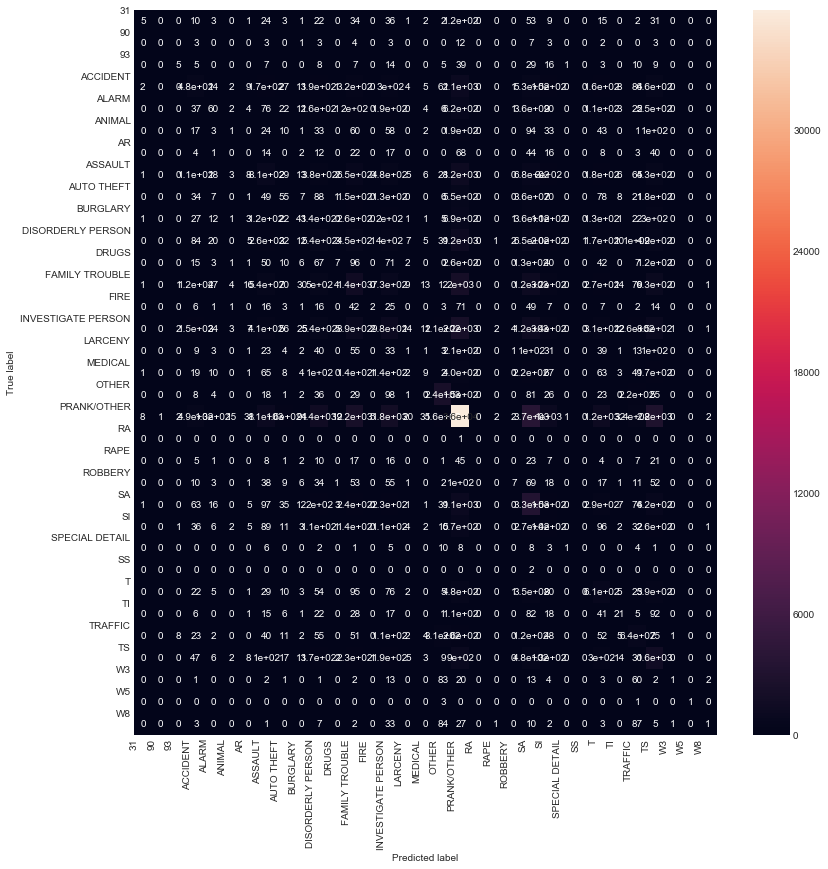

In [171]:
# Create confusion matrix
cm_calibration = pd.DataFrame(confusion_matrix(np.array(y_nocd_test), y_predicted_calibration))

fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(cm_calibration, annot=True)
tick_marks = np.arange(len(y_nocd_test.unique()))
plt.xticks(tick_marks, sorted(y_nocd_test.unique()), rotation=90)
plt.yticks(tick_marks, sorted(y_nocd_test.unique()), rotation=0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [172]:
# Classification report
cl_report = classification_report(y_nocd_test, y_predicted_calibration, sample_weight=None, digits=4)
print(cl_report)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

                31     0.2500    0.0132    0.0251       378
                90     0.0000    0.0000    0.0000        44
                93     0.2632    0.0316    0.0565       158
          ACCIDENT     0.2595    0.1169    0.1612      4080
             ALARM     0.1481    0.0268    0.0455      2235
            ANIMAL     0.0270    0.0015    0.0028       669
                AR     0.0000    0.0000    0.0000       251
           ASSAULT     0.1959    0.1509    0.1705      5393
        AUTO THEFT     0.0902    0.0306    0.0457      1799
          BURGLARY     0.1383    0.0175    0.0311      2457
 DISORDERLY PERSON     0.1080    0.1147    0.1112      4691
             DRUGS     0.1400    0.0075    0.0143       930
    FAMILY TROUBLE     0.1816    0.1727    0.1771      8309
              FIRE     0.1667    0.0075    0.0144       266
INVESTIGATE PERSON     0.1503    0.1158    0.1308      8495
           LARCENY     0.0122    0.0015

### Top three predicted classes

From the model's prediction for each observation, we calculated the three predictions with the highest probabilty. Notice that this addition was performed on the original dataset. For the highest probability, the 'prank/other' class is the most frequent; for the second and third highest probability, the classes 'family trouble', 'investigate person' and 'SA' amount as the most frequent classes.  

In [28]:
# Obtain the three highest probability classes (1st, 2nd, 3rd)

# Predict probabilities of selected classes
probs = best_forest.predict_proba(X_nocd_test)

In [29]:
for i in probs[0]:
    print(i)

0.00023247199341082242
0.005026328056158998
5.113687894023047e-05
0.0
0.01935754284767903
0.006318037246561057
0.005407413704417503
0.00014429943351709068
0.11168593738499125
0.012975048332978826
0.007091912214096624
0.03901512113517478
0.1322708451296815
0.07942632120097916
0.005072779670831358
0.12012767739883555
0.00033394700282994577
0.013432506779146149
0.00013414799288045102
0.3391561951453258
0.0
4.643192396837199e-05
0.00034623939956378525
0.0449582411270919
0.005925672367520201
4.535193456587507e-06
2.206582299543748e-06
0.017127858719746668
0.00528132570191559
1.2235891346090383e-06
0.010239259076942071
0.018777375870652688
1.4492454320630708e-05
0.0
1.5468444951120655e-05


In [154]:
# Create a list of keys
list_keys = ['31', '90', '93', '99', 'ACCIDENT', 'ALARM', 'ANIMAL', 'AR',
       'ASSAULT', 'AUTO THEFT', 'BURGLARY', 'DISORDERLY PERSON', 'DRUGS',
       'FAMILY TROUBLE', 'FIRE', 'INVESTIGATE PERSON', 'LARCENY',
       'MEDICAL', 'OTHER', 'PRANK/OTHER', 'RA', 'RAPE', 'ROBBERY', 'SA',
       'SI', 'SPECIAL DETAIL', 'SS', 'T', 'TI', 'TO', 'TRAFFIC', 'TS',
       'W3', 'W5', 'W8']

In [155]:
# Create a list of values
list_values = []
val = 0
for i in list_keys:
    list_keys[val] = []
    for j in probs:
        list_keys[val].append(j[val])
    list_values.append(list_keys[val])
    val += 1

# Restore the list of keys; the list of keys is changed by the previous for loop
list_keys = ['31', '90', '93', '99', 'ACCIDENT', 'ALARM', 'ANIMAL', 'AR',
       'ASSAULT', 'AUTO THEFT', 'BURGLARY', 'DISORDERLY PERSON', 'DRUGS',
       'FAMILY TROUBLE', 'FIRE', 'INVESTIGATE PERSON', 'LARCENY',
       'MEDICAL', 'OTHER', 'PRANK/OTHER', 'RA', 'RAPE', 'ROBBERY', 'SA',
       'SI', 'SPECIAL DETAIL', 'SS', 'T', 'TI', 'TO', 'TRAFFIC', 'TS',
       'W3', 'W5', 'W8']

In [156]:
# Check that the list of keys match the list of values 
print('length: list keys', len(list_keys))
print('length: list values', len(list_values))
print('length: best forest classes', len(best_forest.classes_))
print('length: probs', len(probs))
print('length: list values 0', len(list_values[0]))

length: list keys 35
length: list values 35
length: best forest classes 35
length: probs 116565
length: list values 0 116565


In [159]:
# Zip the two lists into a dictionary
probs_dict = {k: v for k, v in zip(list_keys,list_values)}

### Alternatively
# Zip the 2 lists together into one list of (key,value) tuples: zipped
#zipped = list(zip(list_keys, list_values))
# Build a dictionary with the zipped list: data
#probs_dict = dict(zipped)

### Or 
#probs_dict = dict(zip(list_keys, list_values))

# Create a data frame from the probs_dict
probs_df = pd.DataFrame(probs_dict)

probs_df.head()
probs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116565 entries, 0 to 116564
Data columns (total 35 columns):
31                    116565 non-null float64
90                    116565 non-null float64
93                    116565 non-null float64
99                    116565 non-null float64
ACCIDENT              116565 non-null float64
ALARM                 116565 non-null float64
ANIMAL                116565 non-null float64
AR                    116565 non-null float64
ASSAULT               116565 non-null float64
AUTO THEFT            116565 non-null float64
BURGLARY              116565 non-null float64
DISORDERLY PERSON     116565 non-null float64
DRUGS                 116565 non-null float64
FAMILY TROUBLE        116565 non-null float64
FIRE                  116565 non-null float64
INVESTIGATE PERSON    116565 non-null float64
LARCENY               116565 non-null float64
MEDICAL               116565 non-null float64
OTHER                 116565 non-null float64
PRANK/OTHER    

In [160]:
# Create a column with the label of the predicted class with the highest probability for each row
probs_df['Max'] = probs_df.idxmax(axis=1)
probs_df.head()

,31,90,93,99,ACCIDENT,ALARM,ANIMAL,AR,ASSAULT,AUTO THEFT,...,SS,T,TI,TO,TRAFFIC,TS,W3,W5,W8,Max
0,0.000232,0.005026,0.000051,0.000000,0.019358,0.006318,0.005407,0.000144,0.111686,0.012975,...,2.206582e-06,0.017128,0.005281,1.223589e-06,0.010239,0.018777,0.000014,0.0,0.000015,PRANK/OTHER
1,0.001921,0.000038,0.005295,0.000000,0.048607,0.046366,0.011057,0.000190,0.031594,0.014667,...,2.267355e-06,0.008135,0.005956,3.786919e-07,0.006332,0.014995,0.000254,0.0,0.000117,PRANK/OTHER
2,0.000926,0.000066,0.000179,0.000000,0.030928,0.013875,0.007707,0.006221,0.026082,0.034246,...,3.693544e-06,0.032051,0.001346,7.674406e-06,0.003548,0.062803,0.000081,0.0,0.000086,PRANK/OTHER
3,0.001068,0.005078,0.000311,0.000000,0.044167,0.018965,0.021745,0.005589,0.046490,0.008051,...,7.272576e-06,0.041862,0.001146,1.005443e-06,0.039237,0.024176,0.026415,0.0,0.020454,PRANK/OTHER
4,0.005564,0.000059,0.000210,0.000002,0.083879,0.015117,0.001514,0.000223,0.032027,0.015423,...,1.913656e-07,0.001392,0.010563,1.760315e-06,0.013790,0.026600,0.000086,0.0,0.000147,PRANK/OTHER


In [161]:
# Instead of just looking at the one class with the highest probability, let's look at the top 3 classes
# according to probability

# Copy the data frame
copia_df = probs_df.copy()

# Drop the Max column
copia_df = copia_df.drop('Max', 1)
copia_df.head()

# Transpose copy data drame
copia_t = pd.DataFrame(copia_df).T

# Create a dataframe to store the new labels for the top three highest values
top_3 = pd.DataFrame(np.zeros((0,3)), columns=['Top1','Top2','Top3'])

# Populate the data frame
for i in copia_t.columns:
    df1row = pd.DataFrame(copia_t.nlargest(3, i).index.tolist(), index=['Top1','Top2','Top3']).T
    top_3 = pd.concat([top_3, df1row], axis=0)
    
# Show the data frame
top_3.head()

,Top1,Top2,Top3
0,PRANK/OTHER,DRUGS,INVESTIGATE PERSON
0,PRANK/OTHER,BURGLARY,FAMILY TROUBLE
0,PRANK/OTHER,FAMILY TROUBLE,TS
0,PRANK/OTHER,INVESTIGATE PERSON,FAMILY TROUBLE
0,PRANK/OTHER,INVESTIGATE PERSON,SA


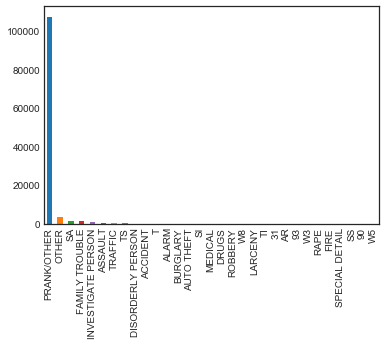

In [162]:
# Plot classes with highest probabilities
top_3['Top1'].value_counts().plot(kind='bar')

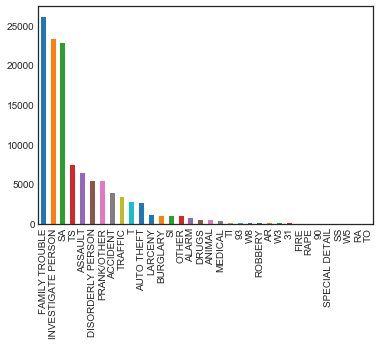

In [163]:
top_3['Top2'].value_counts().plot(kind='bar')

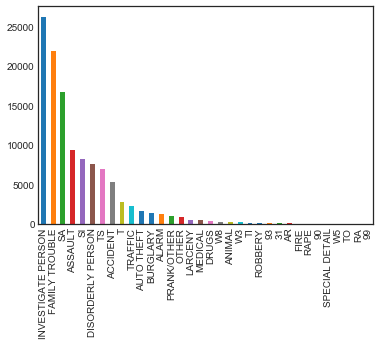

In [164]:
top_3['Top3'].value_counts().plot(kind='bar')

### Recommendations

The model developed here could be used at two different stages of the emergency call ingestion. The first stage occurs at the time the call is made but no information regarding the emergency (e.g. type, location, time of the event, etc.) is available to the dispatcher. At this point, the  model provides the three most likely emergency classes based on basic data including time of the day, day of the week, etc. The goal of this initial suggestion is to narrow down the emergency classes that the dispatcher has to deal with in order to start making decisions as to how to handle the emergency more efficiently. As the emergency call develops and the dispatcher obtains more relevant information from the caller, this information is added to the database allowing the model to narrow down its prediction into a single one. This is the second stage of the modeling in which the most relevant information is available and the model provides predictions at a high confidence level. At this point, the emergency can be dealt with appropiately. This product could be adopted by local 911 units as well as fire and police departments associated with them. 

### Limitations and future research

In this project we have concentrated first only on data from the city of Detroit given its characteristics of a large size American city. Further research should focus on incorporating data from other cities of similar size as well as larger and smaller ones. One of the challenges in adding data from other cities is to find comparable information/features as the ones used here.

The location information in this project was encoded mainly as features for longitude and latitude extracted from the original location feature. Given the high variability of unique values for longitude and latitude, it is possible that some relevant information is not learned by the algorithm. An alternative to this would be to engineer zipcode features from those two features making the data less sparse in this respect and possibly strengthening the learning process. 

Finally, and perhaps most importantly, the actual transcript of the exchange between caller and dispatcher was not available at the time of this project. Having that information has the potential of better informing the model and making predictions in real time as the emergency call develops. This is, after the first stage proposed here, a second step making predictions in real time based on the actual textual information provided by the caller would be added to the prediction stage. 